In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import librosa
import sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

import wget

import matplotlib.pyplot as plt
import librosa.display

import zipfile
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from io import TextIOWrapper

from tqdm import tqdm
import requests


from sklearn.metrics import balanced_accuracy_score

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from scipy.signal import hilbert


import random
from scipy.signal import fftconvolve

from scipy.signal import hilbert
import numpy as np
import librosa
from tqdm import tqdm

In [ ]:
# ----------------------------------------------------------------------------------
# FUNCTIONS
# ----------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------
# DATASET IMPORT, EXTRACTION, ANALYSIS
# ----------------------------------------------------------------------------------

def extract_zip_if_needed(zip_path, extract_to=None):
    """
    Extracts ZIP file if target directory doesn't exist.

    Args:
        zip_path (str): Path to ZIP file
        extract_to (str, optional): Directory to extract files to. If None, uses ZIP filename.

    Returns:
        str: Path to extracted folder
    """
    
    if extract_to is None:
        extract_to = os.path.splitext(zip_path)[0]

    if os.path.exists(extract_to) and os.path.isdir(extract_to):
        print(f"Directory '{extract_to}' already exists, skipping extraction.")
        return extract_to

    
    if os.path.exists(zip_path):
        print(f"Extracting '{zip_path}' to '{extract_to}'...")

        
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            file_list = zip_ref.namelist()
            total_files = len(file_list)

        
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            os.makedirs(extract_to, exist_ok=True)
            for file in tqdm(file_list, desc="Extracting files", total=total_files):
                zip_ref.extract(file, extract_to)

        print(f"Extraction completed in '{extract_to}'")
    else:
        raise FileNotFoundError(f"The ZIP file '{zip_path}' does not exist.")

    return extract_to


def import_idmt_traffic_dataset(fn_txt: str = "idmt_traffic_all") -> pd.DataFrame:
    """Imports IDMT-Traffic dataset
    Args:
        fn_txt (str): Text file containing all WAV filenames
    Returns:
        df_dataset (pd.Dataframe): File metadata with columns:
            'file': WAV filename,
            'is_background': True if recording contains background noise (no vehicle), False otherwise
            'date_time': Recording timestamp (YYYY-MM-DD-HH-mm)
            'location': Recording location
            'speed_kmh': Speed limit at recording site (km/h), UNK if unknown,
            'sample_pos': Sample position (centered) within original recording,
            'daytime': M(orning) or (A)fternoon,
            'weather': (D)ry or (W)et road condition,
            'vehicle': (B)us, (C)ar, (M)otorcycle, or (T)ruck,
            'source_direction': Vehicle direction: from (L)eft or (R)ight,
            'microphone': (SE)= sE8 (high-quality) or (ME) = MEMS (low-quality, ICS-43434),
            'channel': Original stereo pair channel (12) or (34)
    """

    df_files = pd.read_csv(fn_txt, names=('file',))
    fn_file_list = df_files['file'].to_list()

    df_dataset = []

    for f, fn in enumerate(fn_file_list):
        fn = fn.replace('.wav', '')
        parts = fn.split('_')

        # Background noise files
        if '-BG' in fn:
            date_time, location, speed_kmh, sample_pos, mic, channel = parts
            vehicle, source_direction, weather, daytime = 'None', 'None', 'None', 'None'
            is_background = True

        # Files with vehicle passings
        else:
            date_time, location, speed_kmh, sample_pos, daytime, weather, vehicle_direction, mic, channel = parts
            vehicle, source_direction = vehicle_direction
            is_background = False

        channel = channel.replace('-BG', '')
        speed_kmh = speed_kmh.replace('unknownKmh', 'UNK')
        speed_kmh = speed_kmh.replace('Kmh', '')

        df_dataset.append({'file': fn,
                         'is_background': is_background,
                         'date_time': date_time,
                         'location': location,
                         'speed_kmh': speed_kmh,
                         'sample_pos': sample_pos,
                         'daytime': daytime,
                         'weather': weather,
                         'vehicle': vehicle,
                         'source_direction': source_direction,
                         'microphone': mic,
                         'channel': channel})

    df_dataset = pd.DataFrame(df_dataset, columns=('file', 'is_background', 'date_time', 'location', 'speed_kmh', 'sample_pos', 'daytime', 'weather', 'vehicle',
                                               'source_direction', 'microphone', 'channel'))

    return df_dataset


def analyze_audio_channels(file_list):
    """
    Analyzes audio channels in dataset files.

    Args:
        file_list: List of audio file paths

    Returns:
        tuple: (stereo_count, mono_count, file_details)
    """
    mono_count = 0
    stereo_count = 0
    file_details = []

    
    for file_path in tqdm(file_list, desc="Analyzing audio files"):
        try:
            
            y, sr = librosa.load(file_path, sr=None, mono=False)

            # Check if mono or stereo
            if y.ndim == 1:  # Mono (1 channel)
                mono_count += 1
                channels = 1
            else:  # Stereo (2 channels)
                stereo_count += 1
                channels = y.shape[0]

            # Add details
            file_name = os.path.basename(file_path)
            file_details.append({
                'file': file_name,
                'channels': channels,
                'type': 'mono' if channels == 1 else 'stereo'
            })

        except Exception as e:
            print(f"Error analyzing file {file_path}: {e}")

    return stereo_count, mono_count, file_details


# ----------------------------------------------------------------------
# DATA AUGMENTATION
# ----------------------------------------------------------------------

# 1. Noise
def add_noise(y, snr_db=10):
    signal_power = np.mean(y**2)
    snr = 10**(snr_db / 10)
    noise_power = signal_power / snr
    noise = np.random.normal(0, np.sqrt(noise_power), size=y.shape)
    return y + noise

# 2. Pitch shift

def apply_pitch_shift(y, sr):
    is_stereo = y.ndim > 1
    
    if is_stereo:
        # Stereo management
        ch1 = librosa.effects.pitch_shift(y[0], sr=sr, n_steps=2)
        ch2 = librosa.effects.pitch_shift(y[1], sr=sr, n_steps=2)
        
        # Combining channels
        return np.array([ch1, ch2])
    else:
        # Mono original case
        return librosa.effects.pitch_shift(y, sr=sr, n_steps=2)

# 3. Time stretch

def apply_time_stretch(y, rate=1.2):
    is_stereo = y.ndim > 1
    
    if is_stereo:
        
        ch1 = librosa.effects.time_stretch(y[0], rate=rate)
        ch2 = librosa.effects.time_stretch(y[1], rate=rate)
        
        if len(ch1) > len(y[0]):
            ch1 = ch1[:len(y[0])]
        elif len(ch1) < len(y[0]):
            ch1= np.pad(ch1, (0, len(y[0])-len(ch1)), mode='constant', constant_values=(0,0))

        if len(ch2) > len(y[1]):
            ch2 = ch2[:len(y[1])]
        elif len(ch2) < len(y[1]):
            ch2 = np.pad(ch2, (0, len(y[1])-len(ch2)), mode='constant', constant_values=(0,0))
        
        # print(len(y[0]))
        # print(len(y[1]))
        # print(len(ch1))
        # print(len(ch2))

        return np.array([ch1, ch2])
    else:
        
        y_stretched = librosa.effects.time_stretch(y, rate=rate)
        if len(y_stretched) > len(y):
            return y_stretched[:len(y)]
        else:
            return np.pad(y_stretched, (0, len(y) - len(y_stretched)), mode='constant')

'''
def apply_random_crop(y, sr, target_duration=2.0):
    # Rileva se l'audio è stereo o mono
    is_stereo = y.ndim > 1
    
    # Ottiene il numero di campioni correttamente
    if is_stereo:
        n_samples = len(y[0])  # Per audio stereo
    else:
        n_samples = len(y)      # Per audio mono
    
    # Calcola parametri di crop
    crop_duration = random.uniform(0.5, target_duration - 0.01)
    crop_length = np.floor(crop_duration * sr)
    target_length = np.floor(target_duration * sr)
    
    # Gestisce il caso in cui l'audio è più corto della lunghezza di crop
    if n_samples <= crop_length:
        y_crop = y
    else:
        start = np.random.randint(0, n_samples - crop_length)
        if is_stereo:
            y_crop = y[:, start:start + crop_length]  # Slice per stereo
        else:
            y_crop = y[start:start + crop_length]     # Slice per mono
    
    # Padding alla lunghezza target
    if is_stereo:
        crop_samples = y_crop.shape[1]
        y_padded = np.pad(y_crop, ((0, 0), (0, target_length - crop_samples)), mode='constant')
    else:
        y_padded = np.pad(y_crop, (0, target_length - len(y_crop)), mode='constant')
    
    print(len(y[0]))
    print(len(y[1]))
    print(len(y_padded[0]))
    print(len(y_padded[1]))
    
    return y_padded
'''

# Available data augmentation functions
AUGMENTATION_FUNCTIONS = [
    apply_pitch_shift,
    apply_time_stretch,
    add_noise,
    # apply_random_crop
]

# Augmentation principal function
def augment_audio(y, sr, n_augmentations=2):
    """
    Applica n_augmentations funzioni di augmentation casuali all'audio.
    
    Args:
        y: array audio di input (stereo o mono)
        sr: sample rate
        n_augmentations: numero di augmentations da applicare in sequenza
    
    Returns:
        array audio modificato nello stesso formato dell'input
    """
    # Select n_augmentations function randomly from the available list
    selected_augs = random.sample(AUGMENTATION_FUNCTIONS, k=n_augmentations)
    
    
    y_aug = y.copy()
    
    # Apply the augmentation in sequence
    for aug_fn in selected_augs:
        args = aug_fn.__code__.co_varnames
        if 'sr' in args and 'target_duration' in args:
            y_aug = aug_fn(y_aug, sr, target_duration=2.0)
        elif 'sr' in args:
            y_aug = aug_fn(y_aug, sr)
        else:
            y_aug = aug_fn(y_aug)
    
    return y_aug


# ----------------------------------------------------------------------------------
# FEATURE EXTRACTION
# ----------------------------------------------------------------------------------

def normalize_spectrogram(spec):
    spec_min = np.min(spec)
    spec_max = np.max(spec)
    return (spec - spec_min) / (spec_max - spec_min + 1e-6)

def compute_ild_ipd(left, right):
    """
    Calcola ILD e IPD da due canali separati.
    """
    eps = 1e-10
    with np.errstate(divide='ignore', invalid='ignore'):
        ild = 20 * np.log10(np.abs(left) / (np.abs(right) + eps))
        ild[np.isinf(ild)] = 0  
    
    analytic_left = hilbert(left)
    analytic_right = hilbert(right)
    phase_left = np.angle(analytic_left)
    phase_right = np.angle(analytic_right)
    ipd = phase_left - phase_right
    ipd = (ipd + np.pi) % (2 * np.pi) - np.pi
    
    ild_stats = np.array([np.mean(ild), np.std(ild), np.max(ild), np.median(ild)])
    ipd_stats = np.array([np.mean(ipd), np.std(ipd), np.max(ipd), np.median(ipd)])
    
    return ild_stats, ipd_stats



def extract_stats(feature):
    # First calculate statistics across the time/feature dimension (axis=2)
    mean_val = np.mean(feature, axis=2)
    std_val = np.std(feature, axis=2)
    max_val = np.max(feature, axis=2)
    median_val = np.median(feature, axis=2)
    
    # Reshape to remove the middle dimension of 1 and stack the statistics along a new dimension
    # This will result in shape (17506, 4)
    return np.column_stack([
        mean_val.reshape(-1),
        std_val.reshape(-1),
        max_val.reshape(-1),
        median_val.reshape(-1)
    ])


# ----------------------------------------------------------------------------------
# PLOTS
# ----------------------------------------------------------------------------------

def plot_single_output_model(history, y_true, y_pred, class_names=None):
    """
    
Displays training metrics and generates classification report 
for a single-output model using pre-computed predictions.

Args:
    history: History object returned by model.fit()
    y_true: True labels (class indices, not one-hot encoded)
    y_pred: Model predictions (class indices, not one-hot encoded)
    class_names: List of class names (optional)
"""
    
    
    plt.figure(figsize=(12, 5))
    
    # Plot for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    
    best_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(best_acc) + 1
    
    print(f"Miglior accuracy: {best_acc:.4f} (epoch {best_epoch})")
    
    
    if class_names is None:
        class_names = [f'Class {i}' for i in range(len(np.unique(y_true)))]
    
    
    print("\n--- Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def plot_vehicle_test_results(vehicle_true, vehicle_pred, vehicle_class_names, test_results=None):
    """
    
    Displays and evaluates test results for a single-output (vehicle) model.

    Args:
    vehicle_true: True vehicle labels (class indices)
    vehicle_pred: Model predictions for vehicles (class indices)
    vehicle_class_names: List of vehicle class names
    test_results: Model evaluation metrics tuple (loss, accuracy) (optional)


    """
    
    # ----- Performance Statistics -----
    
    print("\n===== VEHICLES CLASSIFICATION RESULTS =====")
    
    # Accuratezza veicoli
    vehicle_accuracy = np.mean(vehicle_true == vehicle_pred)
    print(f"Vehicle accuracy: {vehicle_accuracy:.4f}")
    
    if test_results is not None:
        print(f"Test loss: {test_results[0]:.4f}")
        print(f"Test accuracy: {test_results[1]:.4f}")
    
    
    print("\n--- Vehicle Classification Report ---")
    print(classification_report(vehicle_true, vehicle_pred, target_names=vehicle_class_names))
    
    
    plt.figure(figsize=(12, 10))
    cm_vehicle = confusion_matrix(vehicle_true, vehicle_pred, normalize='true')
    sns.heatmap(cm_vehicle, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=vehicle_class_names, yticklabels=vehicle_class_names)
    plt.title('Vehicle Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Balanced accuracy
    bal_acc = balanced_accuracy_score(vehicle_true, vehicle_pred)
    print(f"\nBalanced accuracy score: {bal_acc:.4f}")

def plot_direction_test_results(direction_true, direction_pred, direction_class_names, test_results=None):
    """
    Displays and evaluates test results for a single-output (direction) model.
    
    Args:
        direction_true: True labels of the directions (class indices)
        direction_pred: Model predictions for directions (class indices)
        direction_class_names: List with the names of the direction classes
        test_results: Tuple with (loss, accuracy) from the model evaluation (optional)

    """
    
    # ----- Performance Statistics -----
    
    print("\n===== DIRECTION CLASSIFICATION RESULTS =====")
    
    # Accuratezza direzioni
    direction_accuracy = np.mean(direction_true == direction_pred)
    print(f"Direction accuracy: {direction_accuracy:.4f}")
    
    if test_results is not None:
        print(f"Test loss: {test_results[0]:.4f}")
        print(f"Test accuracy: {test_results[1]:.4f}")
    
    # Classification report direction
    print("\n--- Direction Classification Report ---")
    print(classification_report(direction_true, direction_pred, target_names=direction_class_names))
    
    # Confusion matrix direction
    plt.figure(figsize=(12, 10))
    cm_direction = confusion_matrix(direction_true, direction_pred, normalize='true')
    sns.heatmap(cm_direction, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=direction_class_names, yticklabels=direction_class_names)
    plt.title('Direction Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Balanced accuracy
    bal_acc = balanced_accuracy_score(direction_true, direction_pred)
    print(f"\nBalanced accuracy score: {bal_acc:.4f}")

    
def plot_and_evaluate_multi_output_model(history,
                                         vehicle_true, vehicle_pred, vehicle_class_names,
                                         direction_true, direction_pred, direction_class_names):
    """
    Displays training metrics and generates classification reports for a dual-output model (vehicle and direction).

    Args:
    history: History object returned by model.fit()
    vehicle_true: True vehicle labels (class indices)
    vehicle_pred: Model predictions for vehicles (class indices)
    vehicle_class_names: List of vehicle class names
    direction_true: True direction labels (class indices)
    direction_pred: Model predictions for direction (class indices)
    direction_class_names: List of direction class names
    """

    # ----- TRAINING METRICS -----

    
    plt.figure(figsize=(15, 10))

    # Plot vehicles accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['vehicle_output_accuracy'], label='Train Vehicle Accuracy')
    plt.plot(history.history['val_vehicle_output_accuracy'], label='Validation Vehicle Accuracy')
    plt.title('Vehicle Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot vehicles loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['vehicle_output_loss'], label='Train Vehicle Loss')
    plt.plot(history.history['val_vehicle_output_loss'], label='Validation Vehicle Loss')
    plt.title('Vehicle Classification Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot direction accuracy
    plt.subplot(2, 2, 3)
    plt.plot(history.history['direction_output_accuracy'], label='Train Direction Accuracy')
    plt.plot(history.history['val_direction_output_accuracy'], label='Validation Direction Accuracy')
    plt.title('Direction Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot direction loss
    plt.subplot(2, 2, 4)
    plt.plot(history.history['direction_output_loss'], label='Train Direction Loss')
    plt.plot(history.history['val_direction_output_loss'], label='Validation Direction Loss')
    plt.title('Direction Classification Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # ----- Performance Statistics -----

    print("\n===== VEHICLES CLASSIFICATION RESULTS =====")

    # Find and print the best accuracy for vehicles
    best_vehicle_acc = max(history.history['val_vehicle_output_accuracy'])
    best_vehicle_epoch = history.history['val_vehicle_output_accuracy'].index(best_vehicle_acc) + 1
    print(f"Best vehicle accuracy: {best_vehicle_acc:.4f} (epoch {best_vehicle_epoch})")

    # Classification report vehicles
    print("\n--- Vehicle Classification Report ---")
    print(classification_report(vehicle_true, vehicle_pred, target_names=vehicle_class_names))

    # Confusion matrix vehicles
    plt.figure(figsize=(12, 8))
    cm_vehicle = confusion_matrix(vehicle_true, vehicle_pred, normalize='true')
    sns.heatmap(cm_vehicle, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=vehicle_class_names, yticklabels=vehicle_class_names)
    plt.title('Vehicle Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    print("\n===== DIRECTION CLASSIFICATION RESULTS =====")

 
    best_direction_acc = max(history.history['val_direction_output_accuracy'])
    best_direction_epoch = history.history['val_direction_output_accuracy'].index(best_direction_acc) + 1
    print(f"Miglior direction accuracy: {best_direction_acc:.4f} (epoch {best_direction_epoch})")

    # Classification report direction
    print("\n--- Direction Classification Report ---")
    print(classification_report(direction_true, direction_pred, target_names=direction_class_names))

    # Confusion matrix direction
    plt.figure(figsize=(10, 8))
    cm_direction = confusion_matrix(direction_true, direction_pred, normalize='true')
    sns.heatmap(cm_direction, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=direction_class_names, yticklabels=direction_class_names)
    plt.title('Direction Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()



def plot_test_results_multi_output_model(vehicle_true, vehicle_pred, vehicle_class_names,
                     direction_true, direction_pred, direction_class_names,
                     test_results=None):
    """
            Display and evaluate test results for a dual-output model (without training and validation plots).
    
    Args:
        vehicle_true: True vehicle labels (class indices)  
        vehicle_pred: Model predictions for vehicles (class indices)  
        vehicle_class_names: List of vehicle class names  
        direction_true: True direction labels (class indices)  
        direction_pred: Model predictions for direction (class indices)  
        direction_class_names: List of direction class names  
        test_results: Model evaluation results (optional)
    """
    
    # ----- Performance Statistics -----
    
    print("\n===== VEHICLES CLASSIFICATION RESULTS =====")
    
    # Vehicles acurracy
    vehicle_accuracy = np.mean(vehicle_true == vehicle_pred)
    print(f"Vehicle accuracy: {vehicle_accuracy:.4f}")
    
    if test_results is not None:
        print(f"Vehicle loss: {test_results[1]:.4f}")
    
    # Classification report veicoli
    print("\n--- Vehicle Classification Report ---")
    print(classification_report(vehicle_true, vehicle_pred, target_names=vehicle_class_names))
    
    # Confusion Matrix Vehicles
    plt.figure(figsize=(12, 8))
    cm_vehicle = confusion_matrix(vehicle_true, vehicle_pred, normalize='true')
    sns.heatmap(cm_vehicle, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=vehicle_class_names, yticklabels=vehicle_class_names)
    plt.title('Vehicle Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    print("\n===== DIRECTION CLASSIFICATION RESULTS =====")
    
    # Direction acurracy
    direction_accuracy = np.mean(direction_true == direction_pred)
    print(f"Direction accuracy: {direction_accuracy:.4f}")
    
    if test_results is not None:
        print(f"Direction loss: {test_results[2]:.4f}")
    
    # Classification report direction
    print("\n--- Direction Classification Report ---")
    print(classification_report(direction_true, direction_pred, target_names=direction_class_names))
    
    # Confusion Matrix Direction
    plt.figure(figsize=(10, 8))
    cm_direction = confusion_matrix(direction_true, direction_pred, normalize='true')
    sns.heatmap(cm_direction, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=direction_class_names, yticklabels=direction_class_names)
    plt.title('Direction Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [ ]:
# ------------------------------------------------------------------------------------
# IMPORT DATASET AND ANALYSIS
# ------------------------------------------------------------------------------------



# ZIP_PATH = "/Volumes/Extreme SSD/IDMT_Traffic.zip" # di Stefano
ZIP_PATH = "IDMT_Traffic.zip"
# AUDIO_DIR = "IDMT_Traffic/audio/"
# ANN_DIR = "IDMT_Traffic/annotation/idmt_traffic_all.txt"

# Download file if it doesn't exist
if not os.path.exists(ZIP_PATH):
    url = "https://zenodo.org/records/7551553/files/IDMT_Traffic.zip?download=1"
    print(f"Downloading {ZIP_PATH}...")
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))

    with open(ZIP_PATH, 'wb') as file:
        with tqdm(
                desc=ZIP_PATH,
                total=total_size,
                unit='iB',
                unit_scale=True,
                unit_divisor=1024,
            ) as bar:
            for data in response.iter_content(chunk_size=1024):
                size = file.write(data)
                bar.update(size)
    print("Download complete!")
else:
    print(f"File {ZIP_PATH} already exists, skipping download.")



extracted_dir = extract_zip_if_needed(ZIP_PATH)

AUDIO_DIR_PATH = os.path.join(extracted_dir, "IDMT_Traffic/audio/")
ANN_FILE_PATH = os.path.join(extracted_dir, "IDMT_Traffic/annotation/idmt_traffic_all.txt")

all_audio_files = [os.path.join(AUDIO_DIR_PATH, f) for f in os.listdir(AUDIO_DIR_PATH) if f.endswith('.wav')]
print(f"\nNumero totale di file audio trovati: {len(all_audio_files)}")


# df_dataset = pd.read_csv(ANN_FILE_PATH, sep="\t", header=None)
df_dataset = import_idmt_traffic_dataset(ANN_FILE_PATH)
vehicle = df_dataset["vehicle"]
direction = df_dataset["source_direction"]
print(np.unique(vehicle))
print(np.unique(direction))


# LABEL ENCODING -----
# Use separate encoders for different label types
le_vehicle = LabelEncoder()
labels_encoded_vehicle = le_vehicle.fit_transform(vehicle)
labels_cat_vehicles = to_categorical(labels_encoded_vehicle)

le_direction = LabelEncoder()
labels_encoded_direction = le_direction.fit_transform(direction)
labels_cat_direction = to_categorical(labels_encoded_direction)


stereo_count, mono_count, details = analyze_audio_channels(all_audio_files)

# print the results
print("\n------ AUDIO CHANNELS ANALYSIS ------")
print(f"Number of stereo files: {stereo_count}")  
print(f"Number of mono files: {mono_count}")  
print(f"Total files analyzed: {stereo_count + mono_count}")  
print(f"Stereo percentage: {stereo_count/(stereo_count + mono_count)*100:.1f}%")  
print(f"Mono percentage: {mono_count/(stereo_count + mono_count)*100:.1f}%")  

df_details = pd.DataFrame(details)
print("\nFirst 5 analized files :")
print(df_details.head())

File IDMT_Traffic.zip already exists, skipping download.
La directory 'IDMT_Traffic' esiste già, l'estrazione verrà saltata.

Numero totale di file audio trovati: 17506
['B' 'C' 'M' 'None' 'T']
['L' 'None' 'R']


Analisi file audio: 100%|██████████| 17506/17506 [02:44<00:00, 106.47it/s]



------ ANALISI CANALI AUDIO ------
Numero di file stereo: 17506
Numero di file mono: 0
Totale file analizzati: 17506
Percentuale stereo: 100.0%
Percentuale mono: 0.0%

Primi 5 file analizzati:
                                                file  channels    tipo
0  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1007744...         2  stereo
1  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1007744...         2  stereo
2  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1017344...         2  stereo
3  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1017344...         2  stereo
4  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1026944...         2  stereo


In [ ]:
# -------------------------------------------------------------------------------------
# FEATURE EXTRACTION
# -------------------------------------------------------------------------------------

spectrograms = []
spectral_centroids = []
spectral_rolloffs = []
spectral_contrasts = []
low_freq_energies = []
fixed_length = None

ild_features = []
ipd_features = []


# --- Common parameters ---
n_fft = 2048
hop_length = 512
n_mels = 128


file_counter = 0
for audio_path in all_audio_files[:]:

    y, sr = librosa.load(audio_path, sr=None, mono=False)

    file_counter += 1

    # Data Augmentation ----
    ''' No data augmentation used '''
    # Augment 1 sample every 10
    # if file_counter % 10 == 0:
    #     y = augment_audio(y, sr, n_augmentations=1)
    
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)


    # 1 centroid for each frame
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    # 1 rolloff for each frame
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)[0]
    # 1 contrast for band (default 6+1 bands)
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)

    low_freq_energy = np.sum(mel_spectrogram[:10, :]) / (np.sum(mel_spectrogram) + 1e-10)

    if fixed_length is None:
        fixed_length = mel_spectrogram_db.shape[1]
    
    # Padding or truncating
    if mel_spectrogram_db.shape[1] < fixed_length:
        mel_spectrogram_db = np.pad(mel_spectrogram_db,
                                    ((0, 0), (0, fixed_length - mel_spectrogram_db.shape[1])),
                                    mode='constant')
    else:
        mel_spectrogram_db = mel_spectrogram_db[:, :fixed_length]
    
    # Normalization
    mel_spectrogram_db = normalize_spectrogram(mel_spectrogram_db)
    
    spectrograms.append(mel_spectrogram_db) 
    spectral_centroids.append(spectral_centroid)
    spectral_rolloffs.append(spectral_rolloff)
    spectral_contrasts.append(spectral_contrast)
    low_freq_energies.append(low_freq_energy)      

    # ILD/IPD stats
    ild_stats, ipd_stats = compute_ild_ipd(y[0], y[1])  # Assuming stereo audio
    ild_features.append(ild_stats)
    ipd_features.append(ipd_stats)


spectrograms = np.array(spectrograms)
spectrograms = spectrograms / np.max(np.abs(spectrograms))

spectral_centroids = np.array(spectral_centroids)
spectral_rolloffs = np.array(spectral_rolloffs)
spectral_contrasts = np.array(spectral_contrasts)
low_freq_energies = np.array(low_freq_energies)

ild_features = np.array(ild_features)
ipd_features = np.array(ipd_features)

input_shape = spectrograms.shape[1:]

print("Spectrograms shape:", spectrograms.shape)
print("Spectral Centroids shape:", spectral_centroids.shape)
print("Spectral Rolloffs shape:", spectral_rolloffs.shape)
print("Spectral Contrasts shape:", spectral_contrasts.shape)
print("Low freq energies shape:", low_freq_energies.shape)
print("ILD features shape:", ild_features.shape)
print("IPD features shape:", ipd_features.shape)
print("Input shape for model:", input_shape)


# Statistics from the features -------------

centroid_stats = extract_stats(spectral_centroids)  # (17506, 4)
rolloff_stats = extract_stats(spectral_rolloffs)    # (17506, 4) 
contrast_stats_left = extract_stats(spectral_contrasts[:, :spectral_contrasts.shape[1] // 2, :])  # Left channel
contrast_stats_right = extract_stats(spectral_contrasts[:, spectral_contrasts.shape[1] // 2:, :])  # Right channel

print(f"Centroid stats shape: {centroid_stats.shape}")
print(f"Rolloff stats shape: {rolloff_stats.shape}")
print(f"Contrast stats shape (left): {contrast_stats_left.shape}")
print(f"Contrast stats shape (right): {contrast_stats_right.shape}")
print(f"Low frequency energies shape: {low_freq_energies.shape}")
print(f"ILD features shape: {ild_features.shape}")
print(f"IPD features shape: {ipd_features.shape}")

audio_features = np.concatenate([
    centroid_stats,                     # (17506, 4)
    rolloff_stats,                      # (17506, 4) 
    contrast_stats_left,                # (17506, 4)
    contrast_stats_right,               # (17506, 4)
    low_freq_energies.reshape(-1, 1),   # (17506, 1)
    ild_features,                       # (17506, 4)
    ipd_features                        # (17506, 4) 
], axis=1)  # Risultato: (17506, 25)

# "Cleaning"
audio_features = np.nan_to_num(audio_features, nan=0.0, posinf=0.0, neginf=0.0)

# Normalize
scaler = StandardScaler()
audio_features_scaled = scaler.fit_transform(audio_features)

print()
print(audio_features_scaled.shape)

Spectrograms shape: (17506, 2, 128, 188)
Spectral Centroids shape: (17506, 1, 188)
Spectral Rolloffs shape: (17506, 1, 188)
Spectral Contrasts shape: (17506, 2, 188)
Low freq energies shape: (17506,)
ILD features shape: (17506, 4)
IPD features shape: (17506, 4)
Input shape for model: (2, 128, 188)
Centroid stats shape: (17506, 4)
Rolloff stats shape: (17506, 4)
Contrast stats shape (left): (17506, 4)
Contrast stats shape (right): (17506, 4)
Low frequency energies shape: (17506,)
ILD features shape: (17506, 4)
IPD features shape: (17506, 4)

(17506, 25)


In [ ]:
# ------------------------------------------------------------------------------
# DATASET SPLIT
# ------------------------------------------------------------------------------

# Dataset split for multi-input and multi-output models (audio features and spectrograms, multiple label types).

# Reshape for CNN (add channel)
print(f"Spectrogram dimensions before reshaping: {spectrograms.shape}")
# spectrograms_reshaped = spectrograms.reshape(spectrograms.shape[0], spectrograms.shape[1], spectrograms.shape[2], 1)
spectrograms_reshaped = spectrograms.transpose(0, 2, 3, 1)  # (17506, 128, 188, 2)
print(f"Spectrogram dimensions after reshaping: {spectrograms_reshaped.shape}")

# 1. First split: Train (70%) e Temporary (30%)
X_train, X_temp, audio_features_train, audio_features_temp, y_train_vehicle, y_temp_vehicle, y_train_direction, y_temp_direction = train_test_split(
    spectrograms_reshaped,
    audio_features_scaled,  
    labels_cat_vehicles,
    labels_cat_direction,
    test_size=0.30,         # 70% train, 30% temporary
    random_state=42,
    shuffle=True
)

# 2. Second split: Temporary in Validation (15%) e Test (15%)
X_val, X_test, audio_features_val, audio_features_test, y_val_vehicle, y_test_vehicle, y_val_direction, y_test_direction = train_test_split(
    X_temp,
    audio_features_temp,   
    y_temp_vehicle,
    y_temp_direction,
    test_size=0.50,        # 15% validation, 15% test 
    random_state=42,
    shuffle=True
)

print()
print(f"Train set: {len(X_train)} campioni")
print(f"Validation set: {len(X_val)} campioni")
print(f"Test set: {len(X_test)} campioni")

# Verifying dimension input for the model
print(f"Spectrogram Dimension input: {X_train.shape[1:]}")
print(f"Feature audio Dimension input : {audio_features_train.shape[1:]}")

Dimensione spettrogrammi prima del reshape: (17506, 2, 128, 188)
Dimensione spettrogrammi dopo il reshape: (17506, 128, 188, 2)

Train set: 12254 campioni
Validation set: 2626 campioni
Test set: 2626 campioni
Dimensione input spettrogrammi: (128, 188, 2)
Dimensione input feature audio: (25,)


In [ ]:
# ------------------------------------------------------------------------------
# MODELLO MONO-OUTPUT - # 17
# ------------------------------------------------------------------------------



# Model definition

# 1. branch CNN for spectrograms
input_spectrogram = tf.keras.Input(shape=spectrograms_reshaped.shape[1:], name='spectrogram_input')

x1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(input_spectrogram)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x1)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x1)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x1)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Flatten()(x1)


# 2. branch for audio feature 
input_features = tf.keras.Input(shape=(audio_features_scaled.shape[1],), name='audio_features_input')

x2 = tf.keras.layers.Dense(64, activation='relu')(input_features)
x2 = tf.keras.layers.Dropout(0.3)(x2)
x2 = tf.keras.layers.Dense(64, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.3)(x2)
x2 = tf.keras.layers.Dense(32, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.3)(x2)

# Fusion of the two branches
merged = tf.keras.layers.Concatenate()([x1, x2])

# Final Dense Layers
x = tf.keras.layers.Dense(1024, activation='relu')(merged)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x_shared = tf.keras.layers.Dense(128, activation='relu')(x)

x_vehicle = tf.keras.layers.Dense(64, activation='relu')(x_shared)
vehicle_output = tf.keras.layers.Dense(5, activation='softmax', name='vehicle_output')(x_vehicle)

# # Output branch per i veicoli
# vehicle_output = tf.keras.layers.Dense(5, activation='softmax', name='vehicle_output')(x)

# # Output branch per la direzione (3 classi: left, right, none)
# direction_output = tf.keras.layers.Dense(3, activation='softmax', name='direction_output')(x)


# Branch for direction
x_direction = tf.keras.layers.Dense(64, activation='relu')(x_shared)
direction_output = tf.keras.layers.Dense(3, activation='softmax', name='direction_output')(x_direction)

model_17 = tf.keras.Model(
    inputs=[input_spectrogram, input_features], 
    outputs=[vehicle_output, direction_output]
)

model_17.summary()


model_17.compile(
    optimizer='adam',
    loss={
        'vehicle_output': 'categorical_crossentropy',
        'direction_output': 'categorical_crossentropy'
    },
    metrics={
        'vehicle_output': ['accuracy'],
        'direction_output': ['accuracy']
    },
    loss_weights={
        'vehicle_output': 2.0, 
        'direction_output': 1.0
    }
)

# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_vehicle_output_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-6
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_17.h5',
    monitor='val_loss',
    save_best_only=True
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ spectrogram_input   │ (None, 128, 188,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 186,  │      1,216 │ spectrogram_inpu… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 93,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 63, 93,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 91,    │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 45,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 30, 45,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 43,    │     18,464 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ audio_features_inp… │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 21,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      1,664 │ audio_features_i… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 14, 21,    │          0 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 19,    │      4,624 │ dropout_2[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      4,160 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 9, 16)  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 6, 9, 16)  │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,595,160 (6.09 MB)

 Trainable params: 1,595,160 (6.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_17 = model_17.fit(
    [X_train, audio_features_train],  
    [y_train_vehicle, y_train_direction],
    epochs=500,
    batch_size=32,
    validation_data=([X_val, audio_features_val], [y_val_vehicle, y_val_direction]),
    callbacks=[reduce_lr, early_stopping, model_checkpoint]
)

Epoch 1/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - direction_output_accuracy: 0.6418 - direction_output_loss: 0.6761 - loss: 1.9641 - vehicle_output_accuracy: 0.7780 - vehicle_output_loss: 0.6440

383/383 ━━━━━━━━━━━━━━━━━━━━ 64s 149ms/step - direction_output_accuracy: 0.6419 - direction_output_loss: 0.6758 - loss: 1.9629 - vehicle_output_accuracy: 0.7782 - vehicle_output_loss: 0.6436 - val_direction_output_accuracy: 0.6858 - val_direction_output_loss: 0.5228 - val_loss: 1.7723 - val_vehicle_output_accuracy: 0.8591 - val_vehicle_output_loss: 0.6315 - learning_rate: 0.0010
Epoch 2/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - direction_output_accuracy: 0.7561 - direction_output_loss: 0.4420 - loss: 1.1515 - vehicle_output_accuracy: 0.8915 - vehicle_output_loss: 0.3547

383/383 ━━━━━━━━━━━━━━━━━━━━ 55s 142ms/step - direction_output_accuracy: 0.7562 - direction_output_loss: 0.4420 - loss: 1.1514 - vehicle_output_accuracy: 0.8915 - vehicle_output_loss: 0.3547 - val_direction_output_accuracy: 0.7315 - val_direction_output_loss: 0.5073 - val_loss: 1.6764 - val_vehicle_output_accuracy: 0.8770 - val_vehicle_output_loss: 0.5908 - learning_rate: 0.0010
Epoch 3/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - direction_output_accuracy: 0.8027 - direction_output_loss: 0.4003 - loss: 1.0490 - vehicle_output_accuracy: 0.9002 - vehicle_output_loss: 0.3243

383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 146ms/step - direction_output_accuracy: 0.8027 - direction_output_loss: 0.4003 - loss: 1.0489 - vehicle_output_accuracy: 0.9002 - vehicle_output_loss: 0.3243 - val_direction_output_accuracy: 0.8576 - val_direction_output_loss: 0.3093 - val_loss: 0.9104 - val_vehicle_output_accuracy: 0.9200 - val_vehicle_output_loss: 0.3013 - learning_rate: 0.0010
Epoch 4/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - direction_output_accuracy: 0.8697 - direction_output_loss: 0.3053 - loss: 0.9345 - vehicle_output_accuracy: 0.9031 - vehicle_output_loss: 0.3146

383/383 ━━━━━━━━━━━━━━━━━━━━ 55s 143ms/step - direction_output_accuracy: 0.8697 - direction_output_loss: 0.3052 - loss: 0.9343 - vehicle_output_accuracy: 0.9031 - vehicle_output_loss: 0.3146 - val_direction_output_accuracy: 0.9040 - val_direction_output_loss: 0.2600 - val_loss: 0.8398 - val_vehicle_output_accuracy: 0.9185 - val_vehicle_output_loss: 0.2892 - learning_rate: 0.0010
Epoch 5/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - direction_output_accuracy: 0.9193 - direction_output_loss: 0.2141 - loss: 0.7735 - vehicle_output_accuracy: 0.9125 - vehicle_output_loss: 0.2797

383/383 ━━━━━━━━━━━━━━━━━━━━ 54s 141ms/step - direction_output_accuracy: 0.9193 - direction_output_loss: 0.2141 - loss: 0.7735 - vehicle_output_accuracy: 0.9125 - vehicle_output_loss: 0.2797 - val_direction_output_accuracy: 0.9631 - val_direction_output_loss: 0.1344 - val_loss: 0.6274 - val_vehicle_output_accuracy: 0.9303 - val_vehicle_output_loss: 0.2459 - learning_rate: 0.0010
Epoch 6/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 54s 140ms/step - direction_output_accuracy: 0.9368 - direction_output_loss: 0.1755 - loss: 0.7303 - vehicle_output_accuracy: 0.9139 - vehicle_output_loss: 0.2774 - val_direction_output_accuracy: 0.9688 - val_direction_output_loss: 0.1397 - val_loss: 0.7347 - val_vehicle_output_accuracy: 0.9235 - val_vehicle_output_loss: 0.2972 - learning_rate: 0.0010
Epoch 7/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - direction_output_accuracy: 0.9492 - direction_output_loss: 0.1485 - loss: 0.6785 - vehicle_output_accuracy: 0.9186 - vehicle_output_loss: 0.2650

383/383 ━━━━━━━━━━━━━━━━━━━━ 54s 141ms/step - direction_output_accuracy: 0.9492 - direction_output_loss: 0.1485 - loss: 0.6785 - vehicle_output_accuracy: 0.9185 - vehicle_output_loss: 0.2650 - val_direction_output_accuracy: 0.9779 - val_direction_output_loss: 0.0781 - val_loss: 0.5287 - val_vehicle_output_accuracy: 0.9334 - val_vehicle_output_loss: 0.2244 - learning_rate: 0.0010
Epoch 8/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 54s 140ms/step - direction_output_accuracy: 0.9595 - direction_output_loss: 0.1190 - loss: 0.6408 - vehicle_output_accuracy: 0.9123 - vehicle_output_loss: 0.2609 - val_direction_output_accuracy: 0.9787 - val_direction_output_loss: 0.0642 - val_loss: 0.5301 - val_vehicle_output_accuracy: 0.9330 - val_vehicle_output_loss: 0.2324 - learning_rate: 0.0010
Epoch 9/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - direction_output_accuracy: 0.9596 - direction_output_loss: 0.1170 - loss: 0.5981 - vehicle_output_accuracy: 0.9214 - vehicle_output_loss: 0.2405

383/383 ━━━━━━━━━━━━━━━━━━━━ 54s 141ms/step - direction_output_accuracy: 0.9596 - direction_output_loss: 0.1170 - loss: 0.5981 - vehicle_output_accuracy: 0.9214 - vehicle_output_loss: 0.2405 - val_direction_output_accuracy: 0.9798 - val_direction_output_loss: 0.0564 - val_loss: 0.4808 - val_vehicle_output_accuracy: 0.9322 - val_vehicle_output_loss: 0.2107 - learning_rate: 0.0010
Epoch 10/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 54s 140ms/step - direction_output_accuracy: 0.9652 - direction_output_loss: 0.1042 - loss: 0.5912 - vehicle_output_accuracy: 0.9195 - vehicle_output_loss: 0.2435 - val_direction_output_accuracy: 0.9817 - val_direction_output_loss: 0.0812 - val_loss: 0.5223 - val_vehicle_output_accuracy: 0.9353 - val_vehicle_output_loss: 0.2202 - learning_rate: 0.0010
Epoch 11/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - direction_output_accuracy: 0.9681 - direction_output_loss: 0.0994 - loss: 0.5542 - vehicle_output_accuracy: 0.9254 - vehicle_output_loss: 0.2274

383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 147ms/step - direction_output_accuracy: 0.9680 - direction_output_loss: 0.0994 - loss: 0.5543 - vehicle_output_accuracy: 0.9254 - vehicle_output_loss: 0.2274 - val_direction_output_accuracy: 0.9821 - val_direction_output_loss: 0.0576 - val_loss: 0.4586 - val_vehicle_output_accuracy: 0.9364 - val_vehicle_output_loss: 0.2000 - learning_rate: 0.0010
Epoch 12/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 62s 161ms/step - direction_output_accuracy: 0.9670 - direction_output_loss: 0.0959 - loss: 0.5479 - vehicle_output_accuracy: 0.9248 - vehicle_output_loss: 0.2260 - val_direction_output_accuracy: 0.9760 - val_direction_output_loss: 0.0766 - val_loss: 0.4993 - val_vehicle_output_accuracy: 0.9330 - val_vehicle_output_loss: 0.2098 - learning_rate: 0.0010
Epoch 13/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 63s 165ms/step - direction_output_accuracy: 0.9699 - direction_output_loss: 0.0946 - loss: 0.5454 - vehicle_output_accuracy: 0.9222 - vehicle_output_loss: 0.2254 - val_direction_out

383/383 ━━━━━━━━━━━━━━━━━━━━ 64s 166ms/step - direction_output_accuracy: 0.9706 - direction_output_loss: 0.0870 - loss: 0.5267 - vehicle_output_accuracy: 0.9244 - vehicle_output_loss: 0.2198 - val_direction_output_accuracy: 0.9783 - val_direction_output_loss: 0.0634 - val_loss: 0.4550 - val_vehicle_output_accuracy: 0.9360 - val_vehicle_output_loss: 0.1942 - learning_rate: 0.0010
Epoch 15/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 64s 166ms/step - direction_output_accuracy: 0.9718 - direction_output_loss: 0.0862 - loss: 0.5197 - vehicle_output_accuracy: 0.9260 - vehicle_output_loss: 0.2167 - val_direction_output_accuracy: 0.9791 - val_direction_output_loss: 0.0755 - val_loss: 0.4972 - val_vehicle_output_accuracy: 0.9372 - val_vehicle_output_loss: 0.2103 - learning_rate: 0.0010
Epoch 16/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - direction_output_accuracy: 0.9703 - direction_output_loss: 0.0932 - loss: 0.5461 - vehicle_output_accuracy: 0.9230 - vehicle_output_loss: 0.2264

383/383 ━━━━━━━━━━━━━━━━━━━━ 63s 163ms/step - direction_output_accuracy: 0.9703 - direction_output_loss: 0.0932 - loss: 0.5460 - vehicle_output_accuracy: 0.9230 - vehicle_output_loss: 0.2264 - val_direction_output_accuracy: 0.9836 - val_direction_output_loss: 0.0498 - val_loss: 0.4201 - val_vehicle_output_accuracy: 0.9395 - val_vehicle_output_loss: 0.1839 - learning_rate: 0.0010
Epoch 17/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 60s 156ms/step - direction_output_accuracy: 0.9730 - direction_output_loss: 0.0787 - loss: 0.5012 - vehicle_output_accuracy: 0.9287 - vehicle_output_loss: 0.2113 - val_direction_output_accuracy: 0.9813 - val_direction_output_loss: 0.0566 - val_loss: 0.4446 - val_vehicle_output_accuracy: 0.9364 - val_vehicle_output_loss: 0.1929 - learning_rate: 0.0010
Epoch 18/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 147ms/step - direction_output_accuracy: 0.9755 - direction_output_loss: 0.0694 - loss: 0.4629 - vehicle_output_accuracy: 0.9321 - vehicle_output_loss: 0.1968 - val_direction_out

383/383 ━━━━━━━━━━━━━━━━━━━━ 58s 150ms/step - direction_output_accuracy: 0.9732 - direction_output_loss: 0.0787 - loss: 0.4790 - vehicle_output_accuracy: 0.9271 - vehicle_output_loss: 0.2002 - val_direction_output_accuracy: 0.9871 - val_direction_output_loss: 0.0380 - val_loss: 0.3881 - val_vehicle_output_accuracy: 0.9410 - val_vehicle_output_loss: 0.1737 - learning_rate: 0.0010
Epoch 20/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - direction_output_accuracy: 0.9764 - direction_output_loss: 0.0688 - loss: 0.4512 - vehicle_output_accuracy: 0.9340 - vehicle_output_loss: 0.1912

383/383 ━━━━━━━━━━━━━━━━━━━━ 57s 150ms/step - direction_output_accuracy: 0.9764 - direction_output_loss: 0.0688 - loss: 0.4512 - vehicle_output_accuracy: 0.9340 - vehicle_output_loss: 0.1912 - val_direction_output_accuracy: 0.9882 - val_direction_output_loss: 0.0397 - val_loss: 0.3848 - val_vehicle_output_accuracy: 0.9448 - val_vehicle_output_loss: 0.1710 - learning_rate: 0.0010
Epoch 21/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 57s 149ms/step - direction_output_accuracy: 0.9790 - direction_output_loss: 0.0612 - loss: 0.4450 - vehicle_output_accuracy: 0.9353 - vehicle_output_loss: 0.1919 - val_direction_output_accuracy: 0.9867 - val_direction_output_loss: 0.0548 - val_loss: 0.4494 - val_vehicle_output_accuracy: 0.9410 - val_vehicle_output_loss: 0.1960 - learning_rate: 0.0010
Epoch 22/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 57s 148ms/step - direction_output_accuracy: 0.9788 - direction_output_loss: 0.0631 - loss: 0.4503 - vehicle_output_accuracy: 0.9297 - vehicle_output_loss: 0.1936 - val_direction_out

383/383 ━━━━━━━━━━━━━━━━━━━━ 51s 133ms/step - direction_output_accuracy: 0.9821 - direction_output_loss: 0.0556 - loss: 0.4403 - vehicle_output_accuracy: 0.9322 - vehicle_output_loss: 0.1923 - val_direction_output_accuracy: 0.9867 - val_direction_output_loss: 0.0437 - val_loss: 0.3816 - val_vehicle_output_accuracy: 0.9467 - val_vehicle_output_loss: 0.1674 - learning_rate: 0.0010
Epoch 30/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - direction_output_accuracy: 0.9834 - direction_output_loss: 0.0534 - loss: 0.4141 - vehicle_output_accuracy: 0.9337 - vehicle_output_loss: 0.1803

383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - direction_output_accuracy: 0.9834 - direction_output_loss: 0.0534 - loss: 0.4141 - vehicle_output_accuracy: 0.9337 - vehicle_output_loss: 0.1803 - val_direction_output_accuracy: 0.9871 - val_direction_output_loss: 0.0402 - val_loss: 0.3672 - val_vehicle_output_accuracy: 0.9421 - val_vehicle_output_loss: 0.1619 - learning_rate: 0.0010
Epoch 31/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - direction_output_accuracy: 0.9836 - direction_output_loss: 0.0520 - loss: 0.4035 - vehicle_output_accuracy: 0.9333 - vehicle_output_loss: 0.1757

383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 147ms/step - direction_output_accuracy: 0.9836 - direction_output_loss: 0.0520 - loss: 0.4035 - vehicle_output_accuracy: 0.9333 - vehicle_output_loss: 0.1757 - val_direction_output_accuracy: 0.9886 - val_direction_output_loss: 0.0410 - val_loss: 0.3627 - val_vehicle_output_accuracy: 0.9490 - val_vehicle_output_loss: 0.1594 - learning_rate: 0.0010
Epoch 32/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 57s 149ms/step - direction_output_accuracy: 0.9865 - direction_output_loss: 0.0438 - loss: 0.3904 - vehicle_output_accuracy: 0.9404 - vehicle_output_loss: 0.1733 - val_direction_output_accuracy: 0.9855 - val_direction_output_loss: 0.0516 - val_loss: 0.3996 - val_vehicle_output_accuracy: 0.9433 - val_vehicle_output_loss: 0.1724 - learning_rate: 0.0010
Epoch 33/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 52s 135ms/step - direction_output_accuracy: 0.9864 - direction_output_loss: 0.0422 - loss: 0.3871 - vehicle_output_accuracy: 0.9342 - vehicle_output_loss: 0.1724 - val_direction_out

383/383 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - direction_output_accuracy: 0.9848 - direction_output_loss: 0.0500 - loss: 0.3970 - vehicle_output_accuracy: 0.9388 - vehicle_output_loss: 0.1735 - val_direction_output_accuracy: 0.9874 - val_direction_output_loss: 0.0357 - val_loss: 0.3561 - val_vehicle_output_accuracy: 0.9474 - val_vehicle_output_loss: 0.1586 - learning_rate: 0.0010
Epoch 38/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 48s 124ms/step - direction_output_accuracy: 0.9853 - direction_output_loss: 0.0447 - loss: 0.3713 - vehicle_output_accuracy: 0.9408 - vehicle_output_loss: 0.1633 - val_direction_output_accuracy: 0.9882 - val_direction_output_loss: 0.0391 - val_loss: 0.3624 - val_vehicle_output_accuracy: 0.9440 - val_vehicle_output_loss: 0.1600 - learning_rate: 0.0010
Epoch 39/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - direction_output_accuracy: 0.9856 - direction_output_loss: 0.0447 - loss: 0.3678 - vehicle_output_accuracy: 0.9388 - vehicle_output_loss: 0.1615 - val_direction_out

383/383 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - direction_output_accuracy: 0.9862 - direction_output_loss: 0.0406 - loss: 0.3587 - vehicle_output_accuracy: 0.9406 - vehicle_output_loss: 0.1590 - val_direction_output_accuracy: 0.9882 - val_direction_output_loss: 0.0351 - val_loss: 0.3326 - val_vehicle_output_accuracy: 0.9501 - val_vehicle_output_loss: 0.1470 - learning_rate: 0.0010
Epoch 42/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - direction_output_accuracy: 0.9871 - direction_output_loss: 0.0431 - loss: 0.3637 - vehicle_output_accuracy: 0.9416 - vehicle_output_loss: 0.1603 - val_direction_output_accuracy: 0.9836 - val_direction_output_loss: 0.0687 - val_loss: 0.4386 - val_vehicle_output_accuracy: 0.9398 - val_vehicle_output_loss: 0.1828 - learning_rate: 0.0010
Epoch 43/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - direction_output_accuracy: 0.9880 - direction_output_loss: 0.0359 - loss: 0.3570 - vehicle_output_accuracy: 0.9399 - vehicle_output_loss: 0.1605 - val_direction_out

In [ ]:
# TEST
best_model_17 = tf.keras.models.load_model('best_model_17.h5')

# Evaluate with both outputs
test_results = best_model_17.evaluate(
    [X_test, audio_features_test],
    [y_test_vehicle, y_test_direction], 
    verbose=1
)
print(f"\nTest accuracy (vehicle): {test_results[3]:.4f}")
print(f"Test loss (vehicle): {test_results[1]:.4f}")
print(f"Test accuracy (direction): {test_results[4]:.4f}")
print(f"Test loss (direction): {test_results[2]:.4f}")

# Get predictions for both outputs
vehicle_pred_prob, direction_pred_prob = best_model_17.predict([X_test, audio_features_test])

# Process each output separately
y_pred_17 = np.argmax(vehicle_pred_prob, axis=1)
y_true_17 = np.argmax(y_test_vehicle, axis=1)

direction_pred_17 = np.argmax(direction_pred_prob, axis=1)
direction_true_17= np.argmax(y_test_direction, axis=1)

83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - direction_output_accuracy: 0.9892 - direction_output_loss: 0.0443 - loss: 0.3845 - vehicle_output_accuracy: 0.9479 - vehicle_output_loss: 0.1701

Test accuracy (vehicle): 0.9897
Test loss (vehicle): 0.1749
Test accuracy (direction): 0.9436
Test loss (direction): 0.0432
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step

===== TRAINING HISTORY AND VALIDATION PREDICTION =====


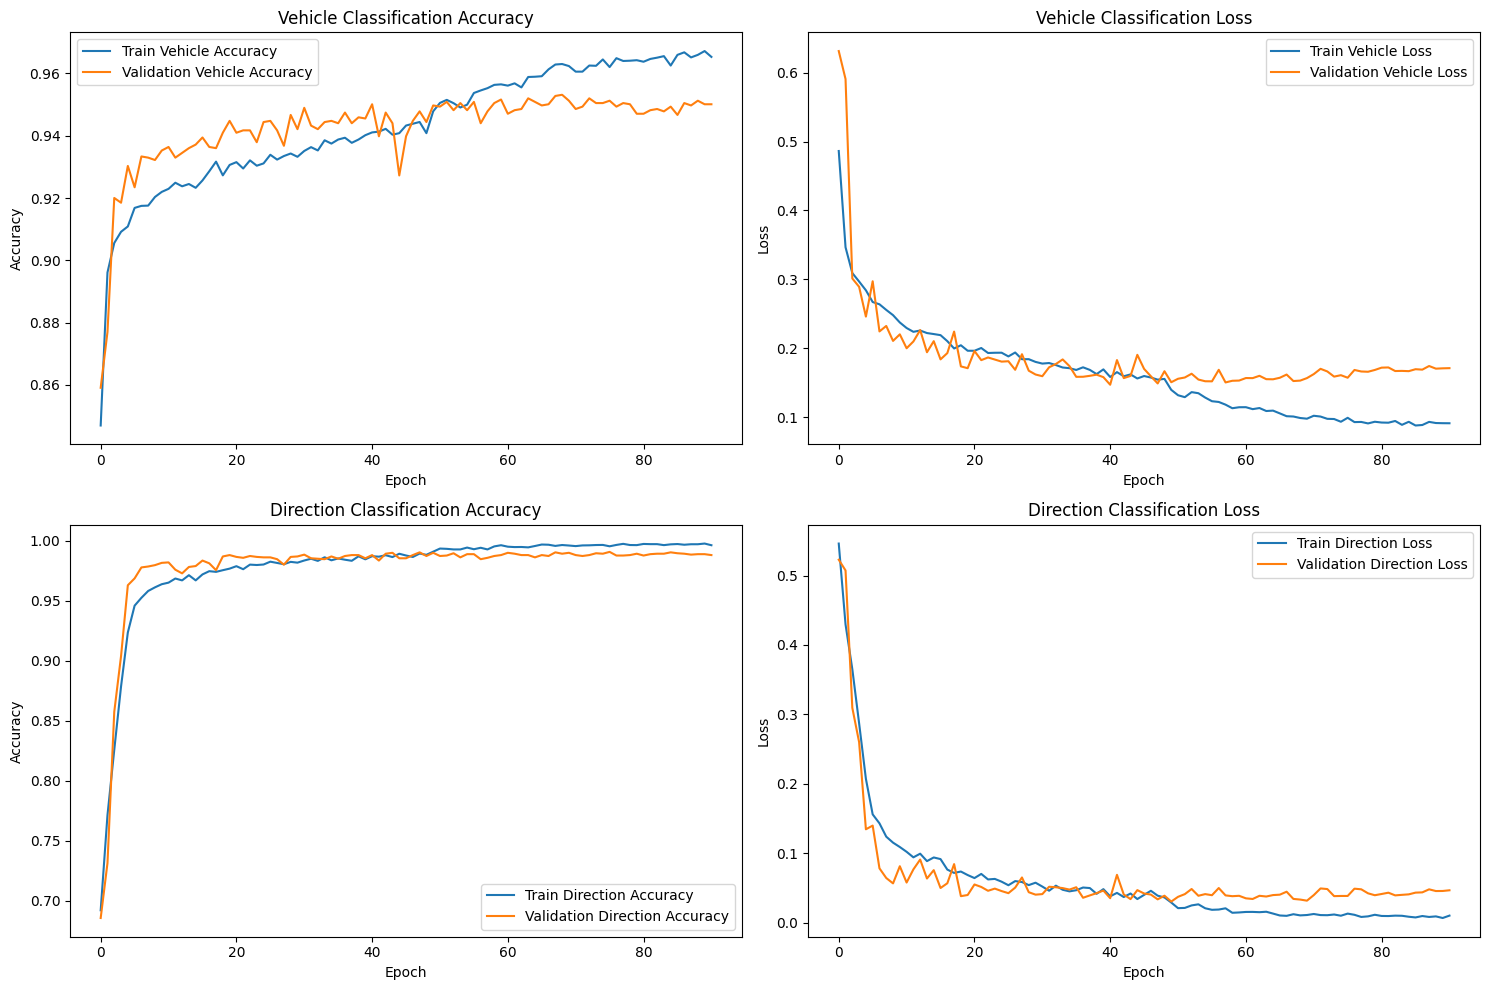


===== RISULTATI CLASSIFICAZIONE VEICOLI =====
Miglior vehicle accuracy: 0.9532 (epoch 69)

--- Vehicle Classification Report ---
              precision    recall  f1-score   support

           B       0.71      0.75      0.73        16
           C       0.92      0.98      0.95      1179
           M       0.99      0.99      0.99        68
        None       0.99      1.00      1.00      1226
           T       0.66      0.28      0.40       137

    accuracy                           0.95      2626
   macro avg       0.85      0.80      0.81      2626
weighted avg       0.94      0.95      0.94      2626



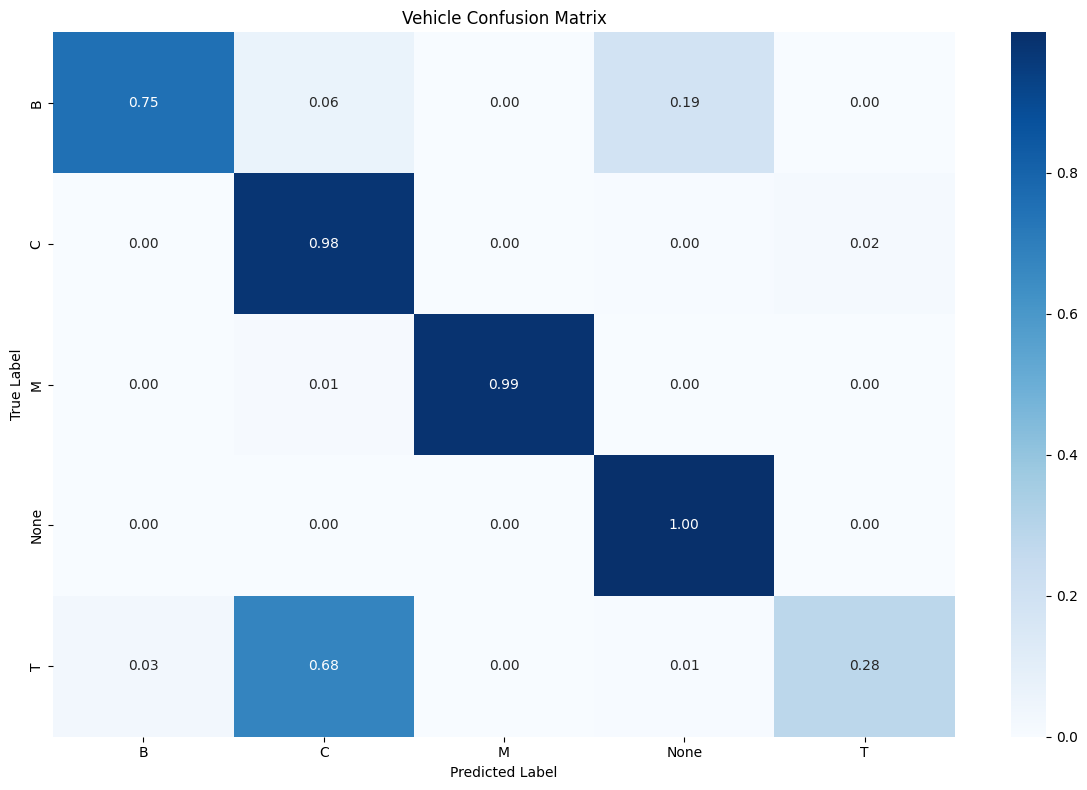


===== RISULTATI CLASSIFICAZIONE DIREZIONE =====
Miglior direction accuracy: 0.9909 (epoch 76)

--- Direction Classification Report ---
              precision    recall  f1-score   support

           L       0.98      0.98      0.98       676
        None       0.99      1.00      1.00      1226
           R       0.99      0.98      0.98       724

    accuracy                           0.99      2626
   macro avg       0.99      0.99      0.99      2626
weighted avg       0.99      0.99      0.99      2626



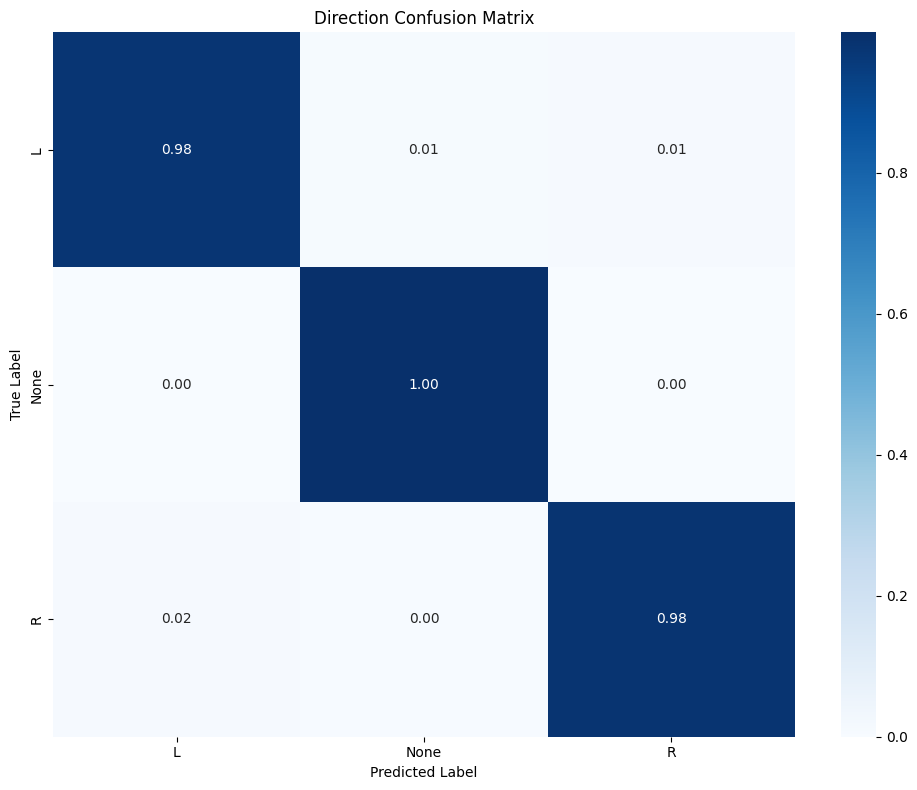


===== TEST RESULTS =====

===== RISULTATI CLASSIFICAZIONE VEICOLI =====
Vehicle accuracy: 0.9436
Vehicle loss: 0.1749

--- Vehicle Classification Report ---
              precision    recall  f1-score   support

           B       0.56      0.45      0.50        22
           C       0.91      0.98      0.95      1177
           M       1.00      0.98      0.99        58
        None       1.00      0.99      1.00      1213
           T       0.68      0.31      0.42       156

    accuracy                           0.94      2626
   macro avg       0.83      0.74      0.77      2626
weighted avg       0.94      0.94      0.93      2626



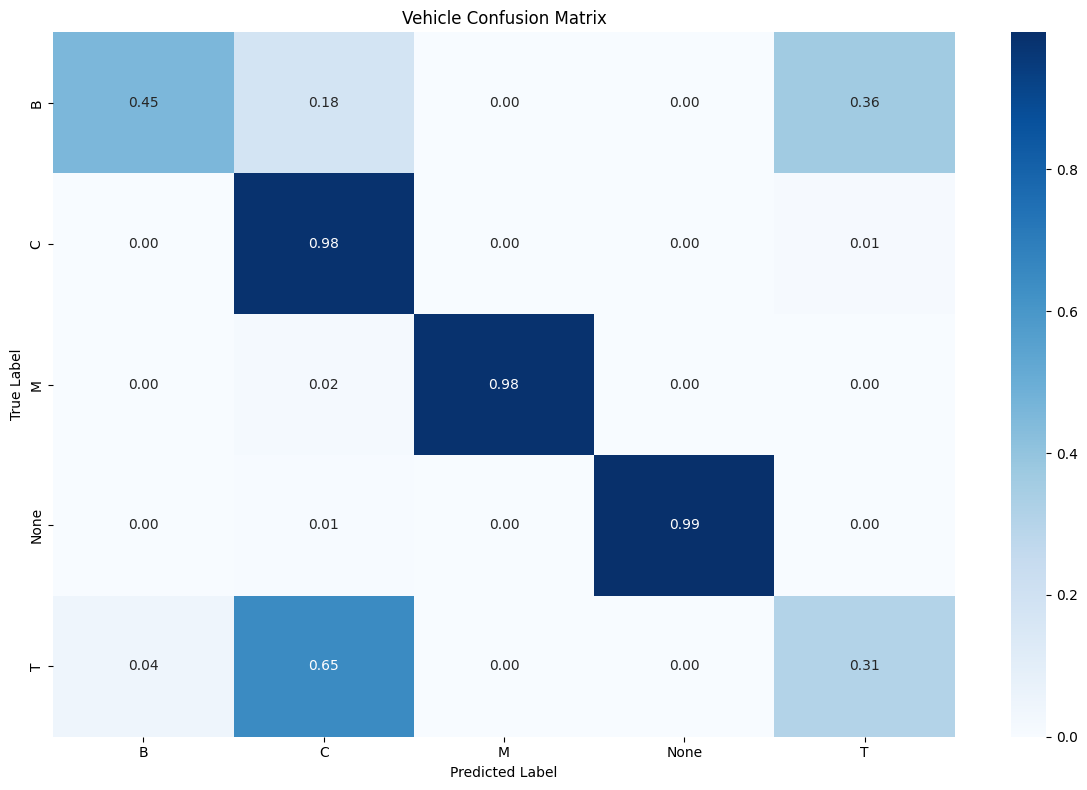


===== RISULTATI CLASSIFICAZIONE DIREZIONE =====
Direction accuracy: 0.9897
Direction loss: 0.0432

--- Direction Classification Report ---
              precision    recall  f1-score   support

           L       0.99      0.98      0.99       715
        None       1.00      0.99      1.00      1213
           R       0.98      0.99      0.99       698

    accuracy                           0.99      2626
   macro avg       0.99      0.99      0.99      2626
weighted avg       0.99      0.99      0.99      2626



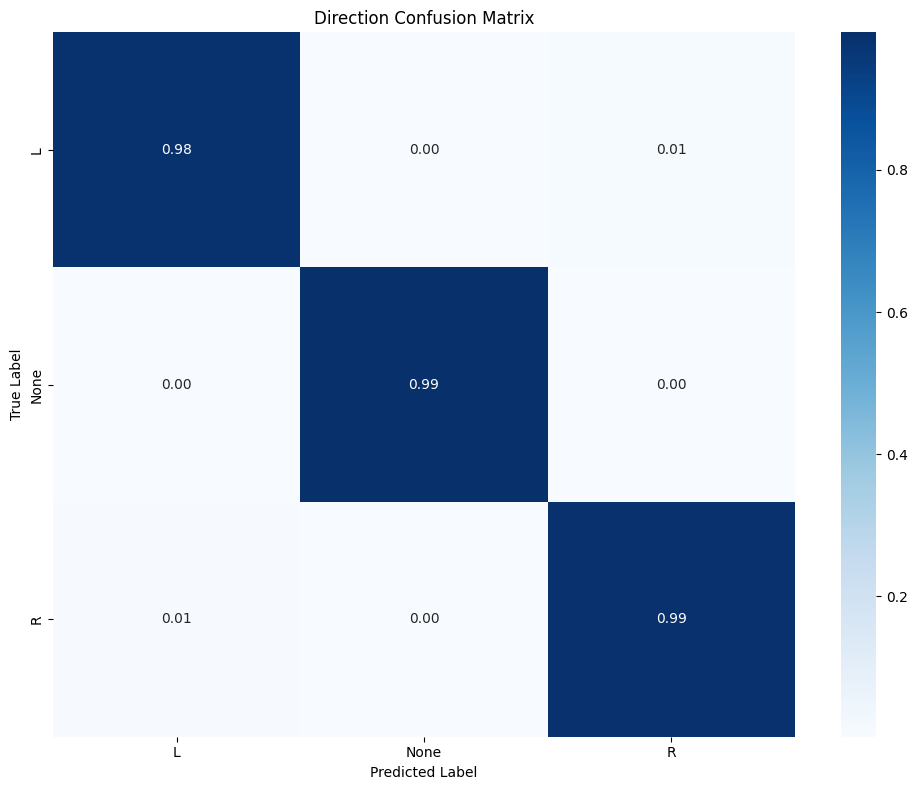

In [ ]:
# Ensure we have class names available
vehicle_class_names = le_vehicle.classes_
direction_class_names = le_direction.classes_

# Get prediction on validation set with the best model
val_vehicle_pred, val_direction_pred = best_model_17.predict([X_val, audio_features_val])

# Process validation output
val_y_pred_17 = np.argmax(val_vehicle_pred, axis=1)
val_y_true_17 = np.argmax(y_val_vehicle, axis=1)

val_direction_pred_17 = np.argmax(val_direction_pred, axis=1)
val_direction_true_17 = np.argmax(y_val_direction, axis=1)

# Visualize training history and valutazione validation
print("\n===== TRAINING HISTORY AND VALIDATION PREDICTION =====")
plot_and_evaluate_multi_output_model(
    history_17,  # Training history
    val_y_true_17, val_y_pred_17, vehicle_class_names,
    val_direction_true_17, val_direction_pred_17, direction_class_names
)

print("\n===== TEST RESULTS =====")
# Plot test results
plot_test_results_multi_output_model(
    y_true_17, y_pred_17, vehicle_class_names,
    direction_true_17, direction_pred_17, direction_class_names,
    test_results
)